# Single-Stock vs NDX — Crisis vs Calm Regression Analysis

Pull data via **yfinance** and run regressions of single-stock returns against **NDX** with a **crisis vs non-crisis** regime split.

What you get:
- OLS baseline and **interaction model** with crisis dummy
- **Newey–West** robust errors
- Residual tests (mean/variance/skew) by regime
- Rolling beta & residual diagnostics



In [1]:
#@title Install & Imports
!pip -q install yfinance pandas numpy statsmodels scipy matplotlib seaborn
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from datetime import datetime
sns.set_context('talk')
pd.options.display.float_format = '{:,.6f}'.format


In [2]:
#@title Parameters
start_date = '2015-01-01'  #@param {type:"string"}
end_date   = ''            #@param {type:"string"}
ndx_ticker = '^NDX'        #@param {type:"string"}
tickers = ['AAPL','MSFT','NVDA','GOOGL','AMZN','META','TSLA']  #@param {type:"raw"}
use_log_returns = True     #@param {type:"boolean"}
winsor_pct = 0.005         #@param {type:"number"}
rolling_window = 60        #@param {type:"integer"}

if not end_date:
    end_date = datetime.today().strftime('%Y-%m-%d')


In [5]:
#@title Data Pull via yfinance
# Data Pull via yfinance (robust to yfinance changes)
all_tickers = [ndx_ticker] + tickers

px_data = yf.download(
    all_tickers,
    start=start_date,
    end=end_date,
    progress=False,
    auto_adjust=False        # <-- force Adj Close to exist
)

# Pick price field safely: prefer Adj Close, fall back to Close
if isinstance(px_data.columns, pd.MultiIndex):
    lvl0 = px_data.columns.get_level_values(0)
    if 'Adj Close' in set(lvl0):
        px = px_data['Adj Close'].copy()
    else:
        px = px_data['Close'].copy()
else:
    # single-ticker case returns a flat frame
    if 'Adj Close' in px_data.columns:
        px = px_data[['Adj Close']].rename(columns={'Adj Close': all_tickers[0]})
    else:
        px = px_data[['Close']].rename(columns={'Close': all_tickers[0]})

# Clean/standardize columns to plain ticker strings
px = px.ffill().dropna(how='all')
if isinstance(px, pd.Series):
    px = px.to_frame()
px.columns = [c if isinstance(c, str) else c[1] for c in px.columns]

# Compute returns
if use_log_returns:
    ret = np.log(px/px.shift(1))
else:
    ret = px.pct_change()
ret = ret.dropna()


In [6]:
#@title Winsorize Returns (optional)
def winsorize(df, p=0.005):
    lo = df.quantile(p)
    hi = df.quantile(1-p)
    return df.clip(lower=lo, upper=hi, axis=1)
ret_w = winsorize(ret, winsor_pct)
ret_w.head()

,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA,^NDX
Date,,,,,,,,
2015-01-05,-0.028576,-0.020731,-0.019238,-0.016192,-0.009238,-0.017035,-0.042950,-0.016513
2015-01-06,0.000094,-0.023098,-0.024989,-0.013565,-0.014786,-0.030788,0.005648,-0.012121
2015-01-07,0.013925,0.010544,-0.002945,0.000000,0.012625,-0.002609,-0.001563,0.011890
2015-01-08,0.037702,0.006813,0.003478,0.026309,0.028994,0.036927,-0.001566,0.019178
2015-01-09,0.001072,-0.011818,-0.012286,-0.005644,-0.008441,0.004020,-0.018981,-0.006452


In [15]:
#@title Crisis Regime Functions
def make_crisis_flag_manual(dates, manual_windows=None):
    """manual_windows: list of (start, end) strings 'YYYY-MM-DD'"""
    flag = pd.Series(0, index=dates)
    if manual_windows:
        for s,e in manual_windows:
            s = pd.to_datetime(s); e = pd.to_datetime(e)
            flag.loc[(flag.index>=s)&(flag.index<=e)] = 1
    return flag

def make_crisis_flag_drawdown(prices, dd_thresh=0.10, lookback=60):
    peak = prices.rolling(lookback).max()
    dd = 1 - prices/peak
    return (dd>=dd_thresh).astype(int)

def make_crisis_flag_vxn(vxn_like, pct=0.90):
    """
    Build a crisis flag from a VXN-like object (Series or DataFrame).
    If a DataFrame is passed, pick a sensible column or squeeze to Series.
    """
    # --- normalize to Series ---
    if isinstance(vxn_like, pd.DataFrame):
        if "Adj Close" in vxn_like.columns:
            s = vxn_like["Adj Close"]
        elif "Close" in vxn_like.columns:
            s = vxn_like["Close"]
        else:
            # squeeze 1-col frame or pick first column
            s = vxn_like.squeeze()
            if isinstance(s, pd.DataFrame):  # still multi-col -> take first
                s = vxn_like.iloc[:, 0]
    else:
        s = vxn_like

    s = pd.to_numeric(s, errors="coerce")

    # --- all-NaN guard (unambiguous) ---
    if s.isna().all():
        return pd.Series(0, index=s.index, dtype=int)

    thr = s.quantile(pct)
    return (s >= thr).astype(int)


def combine_flags(*flags):
    # ensure Series aligned to a common index
    idx = flags[0].index
    parts = [(f.reindex(idx).fillna(0).astype(int)) for f in flags]
    s = sum(parts)
    return (s > 0).astype(int)



In [16]:
#@title Optional: Pull VXN for vol-based crisis flag
# Robust VXN fetch and fallback to realized-vol proxy
def fetch_single_series(ticker, start, end):
    df = yf.download(
        ticker, start=start, end=end,
        progress=False, auto_adjust=False, actions=False, interval="1d"
    )
    if isinstance(df, pd.DataFrame) and not df.empty:
        if "Adj Close" in df.columns:
            s = df["Adj Close"].copy()
        elif "Close" in df.columns:
            s = df["Close"].copy()
        else:
            s = pd.Series(dtype=float)
    else:
        s = pd.Series(dtype=float)
    s.name = ticker
    return s

vxn = fetch_single_series("^VXN", start_date, end_date)
vxn = vxn.reindex(ret_w.index).ffill(limit=5)
vxn.name = "VXN"

# ✅ FIXED: use .isna().sum() instead of .all()
if isinstance(vxn, pd.DataFrame):
    all_nan = vxn.isna().all().all()
else:
    all_nan = vxn.isna().all()

if all_nan:
    print("⚠️  No usable VXN data, falling back to 30D realized vol proxy on NDX.")
    ndx_prices_for_rv = px[ndx_ticker].reindex(ret_w.index)
    rv_ndx = np.log(ndx_prices_for_rv).diff().rolling(30).std() * np.sqrt(252)
    vxn = (rv_ndx * 100.0)  # scale to approximate VXN percentage level
    vxn.name = "NDX_RV_proxy"

vxn.tail()


Ticker,^VXN
Date,
2025-10-02,20.010000
2025-10-03,20.080000
2025-10-06,20.400000
2025-10-07,20.820000
2025-10-08,20.020000


In [23]:
#@title Build Crisis Flag (choose your method)
# Build Crisis Flag (choose your method)

# 1) Manual crisis windows (edit freely)
manual_windows = [
    ("2020-02-20", "2020-04-15"),
    ("2022-04-01", "2022-06-30"),
]

# 2) Safe getter for the NDX price series (prefer existing px, otherwise fetch)
def get_price_series(px_frame, ticker, start, end):
    # Use what's already downloaded if possible
    if isinstance(px_frame, pd.DataFrame) and (ticker in px_frame.columns):
        s = px_frame[ticker].copy()
    else:
        df = yf.download(
            ticker, start=start, end=end,
            progress=False, auto_adjust=False, actions=False, interval="1d"
        )
        if isinstance(df, pd.DataFrame) and not df.empty:
            if "Adj Close" in df.columns:
                s = df["Adj Close"].copy()
            elif "Close" in df.columns:
                s = df["Close"].copy()
            else:
                s = pd.Series(dtype=float)
        else:
            s = pd.Series(dtype=float)
    # Align to the return index you’re using
    s = s.reindex(ret_w.index).ffill()
    s.name = ticker
    return s

# Get NDX prices aligned to your returns index
ndx_prices = get_price_series(px, ndx_ticker, start_date, end_date)

# 3) Build flags: manual, drawdown, VXN (already computed earlier as `vxn`)
flag_manual = make_crisis_flag_manual(ret_w.index, manual_windows)
flag_dd     = make_crisis_flag_drawdown(ndx_prices, dd_thresh=0.10, lookback=60)
flag_vxn    = make_crisis_flag_vxn(vxn, pct=0.90)

# 4) Combine (logical OR) and inspect counts
crisis_flag = combine_flags(flag_dd)
crisis_flag.name = "crisis"

display(crisis_flag.value_counts())


,count
crisis,
0,2374
1,333


In [34]:
#@title Regression Helpers (OLS + Interaction with HAC errors)
def regress_single_vs_ndx_split(ret_df, stock, ndx_col, crisis_flag, lags=5):
    """
    Runs separate regressions of single-stock returns on index returns
    for crisis and non-crisis periods.

    Returns dict of:
    - non_crisis: OLS fit (normal)
    - crisis: OLS fit (crisis)
    - data: merged DataFrame used
    """

    df = pd.DataFrame({
        'y': ret_df[stock],
        'mkt': ret_df[ndx_col],
        'crisis': crisis_flag
    }).dropna()

    # Split by regime
    df_nc = df[df['crisis'] == 0]
    df_c  = df[df['crisis'] == 1]

    # Fit each with HAC (Newey-West) robust SEs
    X_nc = sm.add_constant(df_nc[['mkt']])
    m_nc = sm.OLS(df_nc['y'], X_nc).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

    X_c = sm.add_constant(df_c[['mkt']])
    m_c = sm.OLS(df_c['y'], X_c).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

    return {'non_crisis': m_nc, 'crisis': m_c, 'data': df}


def residual_tests(resid, crisis_flag):
    """
    resid: pandas Series of residuals (index = dates)
    crisis_flag: Series-like of 0/1 (any name). Can be misaligned; we align.
    Returns dict of tests by regime.
    """
    # Ensure Series, align to resid index, coerce to ints, and rename
    cf = pd.Series(crisis_flag).reindex(resid.index).fillna(0).astype(int)
    cf.name = "crisis"

    # Split residuals by regime
    a = resid[cf == 1]  # crisis
    b = resid[cf == 0]  # non-crisis

    # One-sided mean test (crisis mean < 0)
    from scipy import stats
    tstat, p_less = stats.ttest_1samp(a.dropna(), 0.0, alternative="less") if len(a.dropna())>1 else (np.nan, np.nan)

    # Variance test (Levene, robust to non-normality)
    lev_F, lev_p = (np.nan, np.nan)
    if (len(a.dropna())>1) and (len(b.dropna())>1):
        lev_F, lev_p = stats.levene(a.dropna(), b.dropna(), center="median")

    # Skew/kurtosis in crisis residuals
    skew_a = stats.skew(a.dropna()) if len(a.dropna())>2 else np.nan
    kurt_a = stats.kurtosis(a.dropna(), fisher=True) if len(a.dropna())>3 else np.nan

    return {
        "crisis_mean": float(np.nanmean(a)),
        "noncrisis_mean": float(np.nanmean(b)),
        "t_p_less_0": float(p_less) if np.isfinite(p_less) else np.nan,
        "levene_p": float(lev_p) if np.isfinite(lev_p) else np.nan,
        "skew_crisis": float(skew_a) if np.isfinite(skew_a) else np.nan,
        "kurt_crisis": float(kurt_a) if np.isfinite(kurt_a) else np.nan,
    }


In [35]:
#@title Run separate regressions for all tickers (crisis vs non-crisis)
results = {}

for t in tickers:
    subset = ret_w[[t, ndx_ticker]].dropna()

    out = regress_single_vs_ndx_split(subset, t, ndx_ticker, crisis_flag)
    m_nc, m_c, df = out['non_crisis'], out['crisis'], out['data']

    # Residual variance tests (use your existing residual_tests function)
    tests = residual_tests(pd.concat([m_nc.resid, m_c.resid]), df['crisis'])

    # Store key stats
    results[t] = {
        'beta_calm':       float(m_nc.params['mkt']),
        'beta_crisis':     float(m_c.params['mkt']),
        'r2_calm':         float(m_nc.rsquared),
        'r2_crisis':       float(m_c.rsquared),
        'resid_std_calm':  float(m_nc.resid.std()),
        'resid_std_crisis':float(m_c.resid.std()),
        **tests
    }

# Assemble into DataFrame
res_df = pd.DataFrame(results).T

# === Composite score ===
# Higher when: (1) crisis residuals large, (2) Levene p small (strong variance change), (3) beta rises
def z(x):
    return (x - x.mean()) / x.std(ddof=0)

score = (
    z(res_df['resid_std_crisis'] - res_df['resid_std_calm'])   # idio vol expansion
    + z(-np.log(res_df['levene_p'].clip(lower=1e-12)))         # strong variance difference
    + z(res_df['beta_crisis'] - res_df['beta_calm'])           # beta increase
)
res_df['crisis_residual_score'] = score

res_df = res_df.sort_values('crisis_residual_score', ascending=False).round(4)
display(res_df)


,beta_calm,beta_crisis,r2_calm,r2_crisis,resid_std_calm,resid_std_crisis,crisis_mean,noncrisis_mean,t_p_less_0,levene_p,skew_crisis,kurt_crisis,crisis_residual_score
META,1.142800,1.231200,0.484300,0.699700,0.012900,0.018200,0.000000,-0.000000,0.500000,0.000000,-0.017300,1.598800,3.890700
AMZN,1.136600,1.219700,0.540100,0.734900,0.011500,0.016500,0.000000,-0.000000,0.500000,0.000000,-0.278400,6.795800,3.618200
TSLA,1.491000,1.504700,0.253200,0.494100,0.028100,0.034400,-0.000000,-0.000000,0.500000,0.000000,-0.221000,1.025000,0.395500
AAPL,1.018900,1.063200,0.540100,0.800700,0.010300,0.012000,-0.000000,-0.000000,0.500000,0.000000,-0.121000,0.375900,-1.161300
MSFT,1.031300,1.061600,0.659900,0.853800,0.008100,0.009900,0.000000,-0.000000,0.500000,0.000000,0.790300,3.574800,-1.615300
GOOGL,1.028100,1.059800,0.548000,0.804700,0.010300,0.011800,0.000000,-0.000000,0.500000,0.001100,-0.030800,4.862000,-2.268900
NVDA,1.683000,1.659400,0.513500,0.761400,0.018000,0.021000,0.000000,-0.000000,0.500000,0.000300,0.130800,2.744300,-2.858800



=== META vs ^NDX ===
Non-crisis beta: 1.143 | R²: 0.484 | Residual σ: 0.0129
Crisis beta:     1.231 | R²: 0.700 | Residual σ: 0.0182



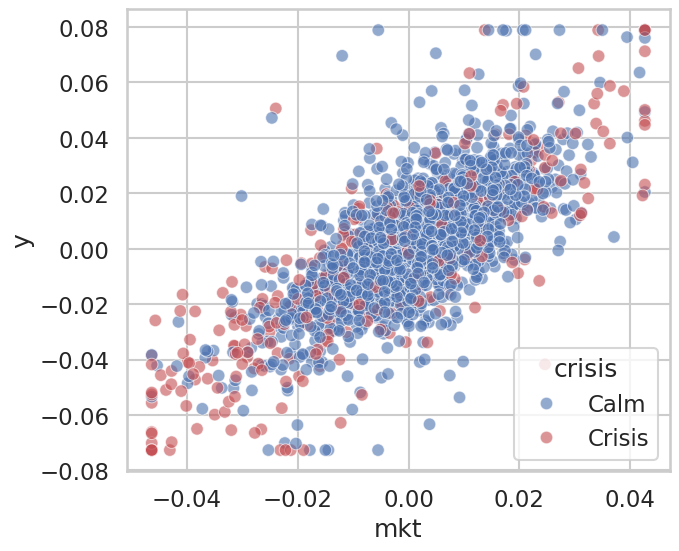

In [36]:
#@title Visualize One Name (Crisis vs Non-Crisis)
name = 'META'  #@param {type:"string"}

# Run split regressions
subset = ret_w[[name, ndx_ticker]].dropna()
out = regress_single_vs_ndx_split(subset, name, ndx_ticker, crisis_flag)
m_nc, m_c, df = out['non_crisis'], out['crisis'], out['data']

print(f"\n=== {name} vs {ndx_ticker} ===")
print(f"Non-crisis beta: {m_nc.params['mkt']:.3f} | R²: {m_nc.rsquared:.3f} | Residual σ: {m_nc.resid.std():.4f}")
print(f"Crisis beta:     {m_c.params['mkt']:.3f} | R²: {m_c.rsquared:.3f} | Residual σ: {m_c.resid.std():.4f}\n")

# --- Scatterplot by regime with fitted lines ---
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(7,6))
sns.scatterplot(
    x=df['mkt'],
    y=df['y'],
    hue=df['crisis'].map({0:'Calm',1:'Crisis'}),
    alpha=0.6,
    palette={'Calm':'#4C72B0','Crisis':'#C44E52'}
)

xline = np.linspace(df['mkt'].min(), df['mkt'].max(), 100)
alpha_nc, beta_nc = m_nc.params['const'],_



META — residual variance diagnostics (split regression)
  Calm std:   0.012950
  Crisis std: 0.018198
  Crisis/Calm std ratio: 1.41
  Levene p-value (variance equality test): 4.24e-17


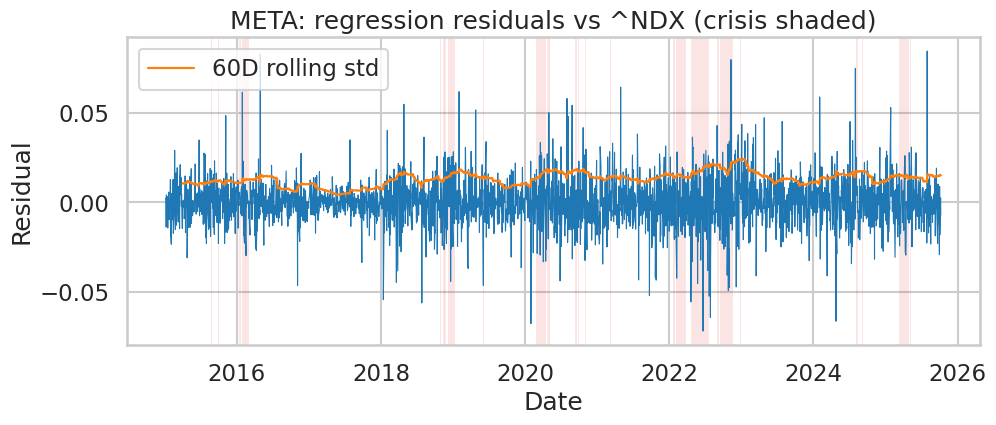

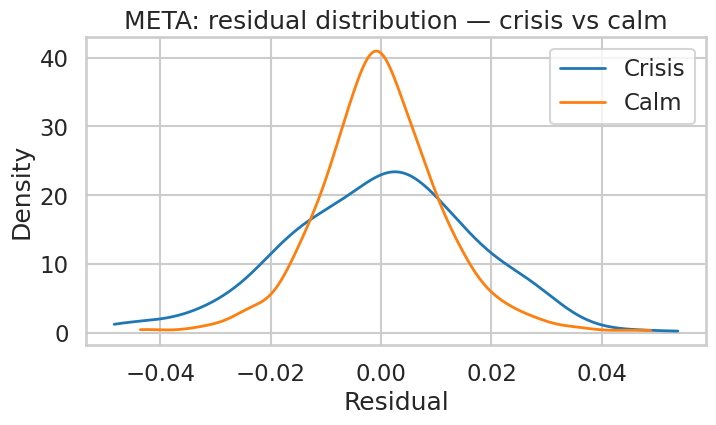

/tmp/ipython-input-3794444576.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([b.values, a.values], labels=["Calm", "Crisis"], showfliers=False)


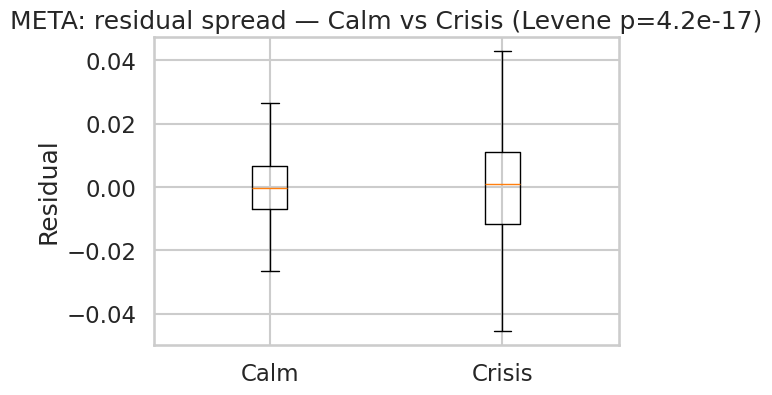

In [38]:
#@title Residual variance widening: visualize & test (split regression)
name = "META"   #@param {type:"string"}
roll_win = 60   #@param {type:"integer"}

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# 1) Run separate regressions for crisis vs non-crisis
subset = ret_w[[name, ndx_ticker]].dropna()
out = regress_single_vs_ndx_split(subset, name, ndx_ticker, crisis_flag)
m_nc, m_c, df = out["non_crisis"], out["crisis"], out["data"]

# Align residuals and crisis flag to master index
resid_nc = m_nc.resid.reindex(ret_w.index)
resid_c  = m_c.resid.reindex(ret_w.index)
flag = pd.Series(crisis_flag).reindex(ret_w.index).fillna(0).astype(int)

# Merge residuals by regime (use crisis-fit residuals in crisis days, calm-fit residuals otherwise)
resid = pd.Series(index=ret_w.index, dtype=float, name="resid")
resid.loc[flag == 0] = resid_nc.loc[flag == 0]
resid.loc[flag == 1] = resid_c.loc[flag == 1]

# 2) Basic stats by regime
a = resid[flag == 1].dropna()  # crisis residuals
b = resid[flag == 0].dropna()  # calm residuals

crisis_std   = a.std(ddof=1)
calm_std     = b.std(ddof=1)
std_ratio    = (crisis_std / calm_std) if (calm_std is not None and np.isfinite(calm_std) and calm_std != 0) else np.nan
lev_F, lev_p = (np.nan, np.nan)
if len(a) > 1 and len(b) > 1:
    lev_F, lev_p = stats.levene(a, b, center="median")

print(f"\n{name} — residual variance diagnostics (split regression)")
print(f"  Calm std:   {calm_std:.6f}")
print(f"  Crisis std: {crisis_std:.6f}")
print(f"  Crisis/Calm std ratio: {std_ratio:.2f}")
print(f"  Levene p-value (variance equality test): {lev_p:.3g}")

# 3) Helper to shade crisis regions
def shade_crisis(ax, crisis_series, color="tab:red", alpha=0.12):
    on = False; start = None
    idx = crisis_series.index
    for t, v in crisis_series.items():
        if (v == 1) and (not on):
            on = True; start = t
        elif (v == 0) and on:
            ax.axvspan(start, t, color=color, alpha=alpha, lw=0); on = False
    if on:
        ax.axvspan(start, idx[-1], color=color, alpha=alpha, lw=0)

# 4) Plot A: residuals with rolling std band and crisis shading
fig, ax = plt.subplots(figsize=(11, 4))
ax.plot(resid.index, resid.values, lw=0.8)
roll_std = resid.rolling(roll_win).std()
ax.plot(roll_std.index, roll_std.values, lw=1.6, label=f"{roll_win}D rolling std")
shade_crisis(ax, flag)
ax.set_title(f"{name}: regression residuals vs {ndx_ticker} (crisis shaded)")
ax.set_xlabel("Date"); ax.set_ylabel("Residual")
ax.legend(loc="upper left")
plt.show()

# 5) Plot B: density comparison (crisis vs calm)
fig, ax = plt.subplots(figsize=(8, 4))
def kde(series, points=400):
    x = series.dropna().values
    if len(x) < 5: return None, None
    k = stats.gaussian_kde(x)
    xs = np.linspace(np.percentile(x, 0.5), np.percentile(x, 99.5), points)
    return xs, k(xs)

xs_a, ya = kde(a); xs_b, yb = kde(b)
if xs_a is not None: ax.plot(xs_a, ya, label="Crisis", lw=2)
if xs_b is not None: ax.plot(xs_b, yb, label="Calm", lw=2)
ax.set_title(f"{name}: residual distribution — crisis vs calm")
ax.set_xlabel("Residual"); ax.set_ylabel("Density")
ax.legend()
plt.show()

# 6) Plot C: boxplot / spread compare
fig, ax = plt.subplots(figsize=(6, 4))
ax.boxplot([b.values, a.values], labels=["Calm", "Crisis"], showfliers=False)
ax.set_title(f"{name}: residual spread — Calm vs Crisis (Levene p={lev_p:.2g})")
ax.set_ylabel("Residual")
plt.show()


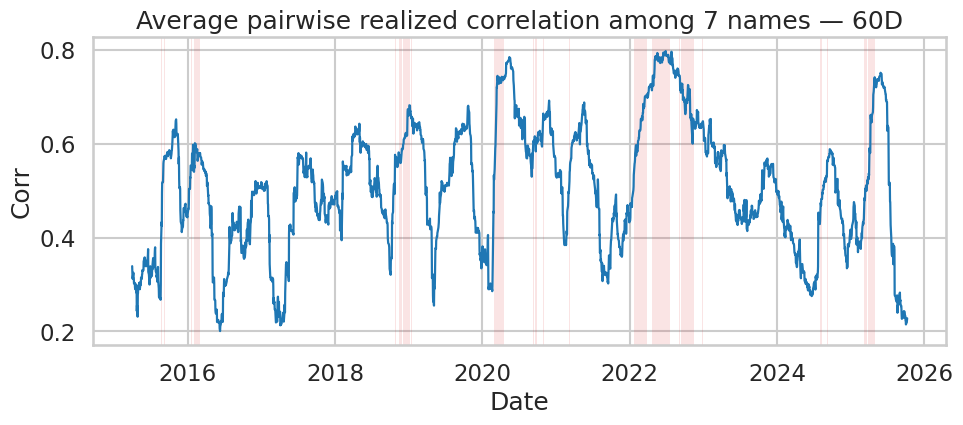

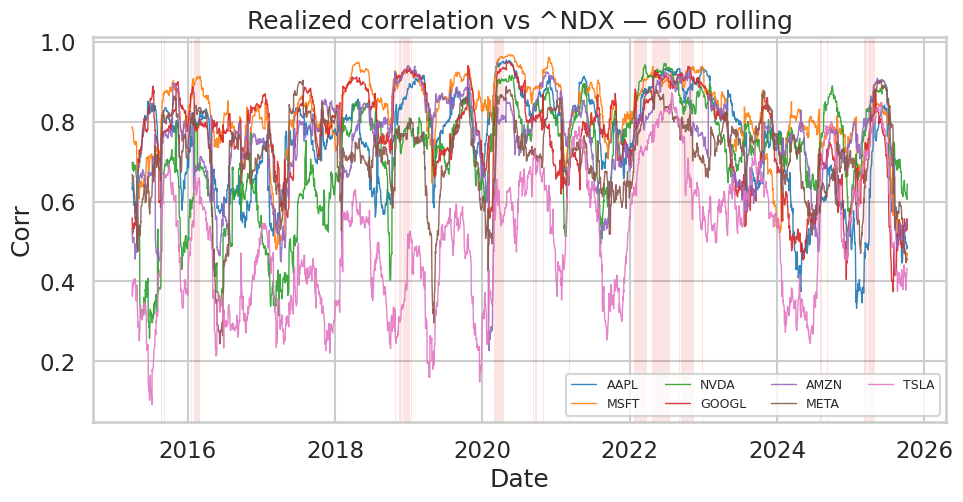

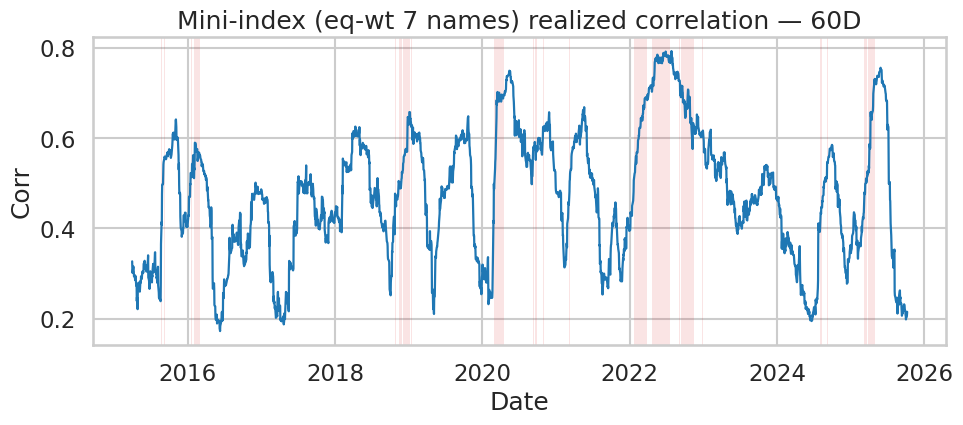

Average realized correlations:
  Pairwise — Crisis: 0.658 | Calm: 0.487
  Mini-index — Crisis: 0.635 | Calm: 0.451


In [39]:
#@title Rolling realized correlation diagnostics (pairwise & vs index)
window = 60  #@param {type:"integer"}

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

R = ret_w[[ndx_ticker] + tickers].dropna()
flag = pd.Series(crisis_flag).reindex(R.index).fillna(0).astype(int)

# --- helper: shade crisis windows on plots ---
def shade_crisis(ax, crisis_series, color="tab:red", alpha=0.12):
    on = False; start = None
    idx = crisis_series.index
    for t, v in crisis_series.items():
        if (v == 1) and (not on):
            on = True; start = t
        elif (v == 0) and on:
            ax.axvspan(start, t, color=color, alpha=alpha, lw=0); on = False
    if on: ax.axvspan(start, idx[-1], color=color, alpha=alpha, lw=0)

# --- 1️⃣ Rolling average pairwise correlation among single names ---
def rolling_avg_pairwise_corr(df, win):
    dates = df.index
    out = pd.Series(index=dates, dtype=float)
    cols = df.columns
    n = len(cols)
    for i in range(win, len(dates)+1):
        sub = df.iloc[i-win:i]
        C = sub.corr().values
        mask = ~np.eye(n, dtype=bool)
        avg_rho = C[mask].mean()
        out.iloc[i-1] = avg_rho
    return out

pair_avg_rho = rolling_avg_pairwise_corr(R[tickers], window)
pair_avg_rho.name = f"Avg pairwise corr ({window}D)"

# --- 2️⃣ Rolling correlation of each stock vs NDX ---
def rolling_corr_vs_index(df, ndx_col, names, win):
    out = pd.DataFrame(index=df.index, columns=names, dtype=float)
    for name in names:
        out[name] = df[ndx_col].rolling(win).corr(df[name])
    return out

rho_vs_ndx = rolling_corr_vs_index(R, ndx_ticker, tickers, window)

# --- 3️⃣ Realized correlation via variance decomposition (equal-weight mini-index) ---
def realized_corr_from_cov(df, win):
    names = df.columns
    N = len(names)
    w = np.full(N, 1.0/N)
    out = pd.Series(index=df.index, dtype=float)
    for i in range(win, len(df)+1):
        sub = df.iloc[i-win:i]
        cov = sub.cov().values
        var_i = np.diag(cov)
        var_basket = float(w @ cov @ w)
        num = var_basket - np.sum((w**2) * var_i)
        denom = 0.0
        for a in range(N):
            for b in range(a+1, N):
                denom += w[a]*w[b]*np.sqrt(var_i[a])*np.sqrt(var_i[b])
        denom *= 2.0
        out.iloc[i-1] = np.nan if np.isclose(denom, 0.0) else num/denom
    return out.clip(-1, 1)

rho_real_mini = realized_corr_from_cov(R[tickers], window)
rho_real_mini.name = f"Mini-index realized corr ({window}D, eq-wt)"

# --- 4️⃣ Plots ---
fig, ax = plt.subplots(figsize=(11,4))
ax.plot(pair_avg_rho, lw=1.6)
shade_crisis(ax, flag)
ax.set_title(f"Average pairwise realized correlation among {len(tickers)} names — {window}D")
ax.set_xlabel("Date"); ax.set_ylabel("Corr")
plt.show()

fig, ax = plt.subplots(figsize=(11,5))
for name in tickers:
    ax.plot(rho_vs_ndx[name], lw=1.0, alpha=0.9, label=name)
shade_crisis(ax, flag)
ax.set_title(f"Realized correlation vs {ndx_ticker} — {window}D rolling")
ax.set_xlabel("Date"); ax.set_ylabel("Corr")
ax.legend(ncols=4, fontsize=9)
plt.show()

fig, ax = plt.subplots(figsize=(11,4))
ax.plot(rho_real_mini, lw=1.6)
shade_crisis(ax, flag)
ax.set_title(f"Mini-index (eq-wt {len(tickers)} names) realized correlation — {window}D")
ax.set_xlabel("Date"); ax.set_ylabel("Corr")
plt.show()

# --- 5️⃣ Summary stats by regime ---
def avg_in_out(series, mask):
    a = series[mask == 1].dropna()
    b = series[mask == 0].dropna()
    return float(a.mean()) if len(a)>0 else np.nan, float(b.mean()) if len(b)>0 else np.nan

pair_c, pair_nc = avg_in_out(pair_avg_rho, flag)
mini_c, mini_nc = avg_in_out(rho_real_mini, flag)

print("Average realized correlations:")
print(f"  Pairwise — Crisis: {pair_c:.3f} | Calm: {pair_nc:.3f}")
print(f"  Mini-index — Crisis: {mini_c:.3f} | Calm: {mini_nc:.3f}")


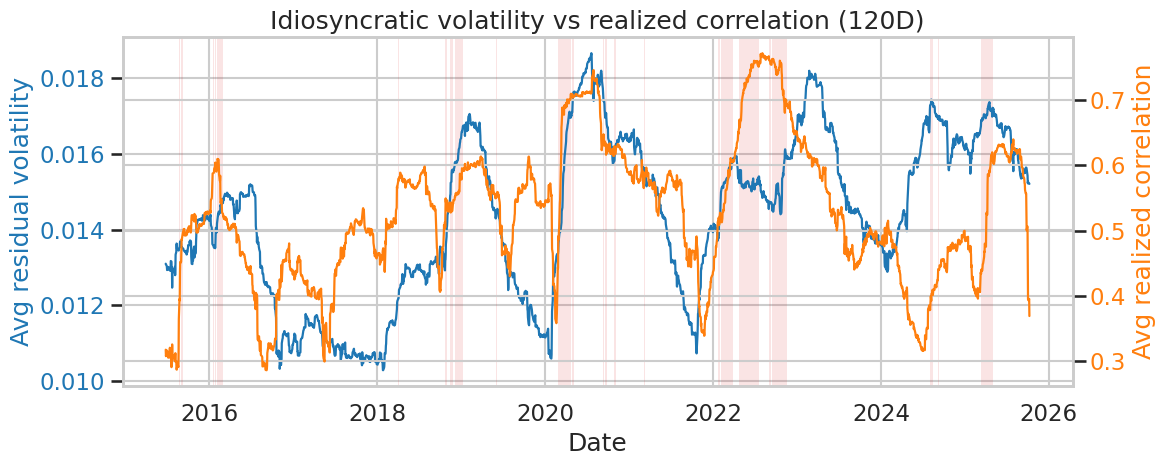

In [40]:
#@title Idiosyncratic volatility vs realized correlation (split regression)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

window = 120  #@param {type:"integer"}

names = tickers.copy()

# --- 1️⃣ Rolling residual volatility (idiosyncratic vol proxy) ---
resid_std = pd.DataFrame(index=ret_w.index, columns=names)

for name in names:
    # run split regressions for each stock
    out = regress_single_vs_ndx_split(ret_w[[name, ndx_ticker]].dropna(), name, ndx_ticker, crisis_flag)
    m_nc, m_c, df = out["non_crisis"], out["crisis"], out["data"]

    # collect residuals from both regimes
    resid_nc = m_nc.resid.reindex(ret_w.index)
    resid_c  = m_c.resid.reindex(ret_w.index)
    flag = pd.Series(crisis_flag).reindex(ret_w.index).fillna(0).astype(int)
    resid = pd.Series(index=ret_w.index, dtype=float)
    resid.loc[flag == 0] = resid_nc.loc[flag == 0]
    resid.loc[flag == 1] = resid_c.loc[flag == 1]

    resid_std[name] = resid.rolling(window).std()

avg_resid_vol = resid_std.mean(axis=1)
avg_resid_vol.name = f"Avg residual std ({window}D)"

# --- 2️⃣ Rolling average realized correlation (from earlier cell) ---
pair_avg_rho = rolling_avg_pairwise_corr(ret_w[names], window)

# --- 3️⃣ Crisis shading helper ---
def shade_crisis(ax, crisis_series, color="tab:red", alpha=0.12):
    on = False; start = None
    idx = crisis_series.index
    for t, v in crisis_series.items():
        if (v == 1) and (not on):
            on = True; start = t
        elif (v == 0) and on:
            ax.axvspan(start, t, color=color, alpha=alpha, lw=0)
            on = False
    if on:
        ax.axvspan(start, idx[-1], color=color, alpha=alpha, lw=0)

flag = pd.Series(crisis_flag).reindex(ret_w.index).fillna(0).astype(int)

# --- 4️⃣ Plot: residual volatility (blue) vs realized correlation (orange) ---
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(avg_resid_vol.index, avg_resid_vol, color="tab:blue", lw=1.6, label="Avg residual volatility")
ax1.set_ylabel("Avg residual volatility", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(pair_avg_rho.index, pair_avg_rho, color="tab:orange", lw=1.6, label="Avg realized correlation")
ax2.set_ylabel("Avg realized correlation", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

shade_crisis(ax1, flag)
ax1.set_title(f"Idiosyncratic volatility vs realized correlation ({window}D)")
ax1.set_xlabel("Date")
fig.tight_layout()
plt.show()


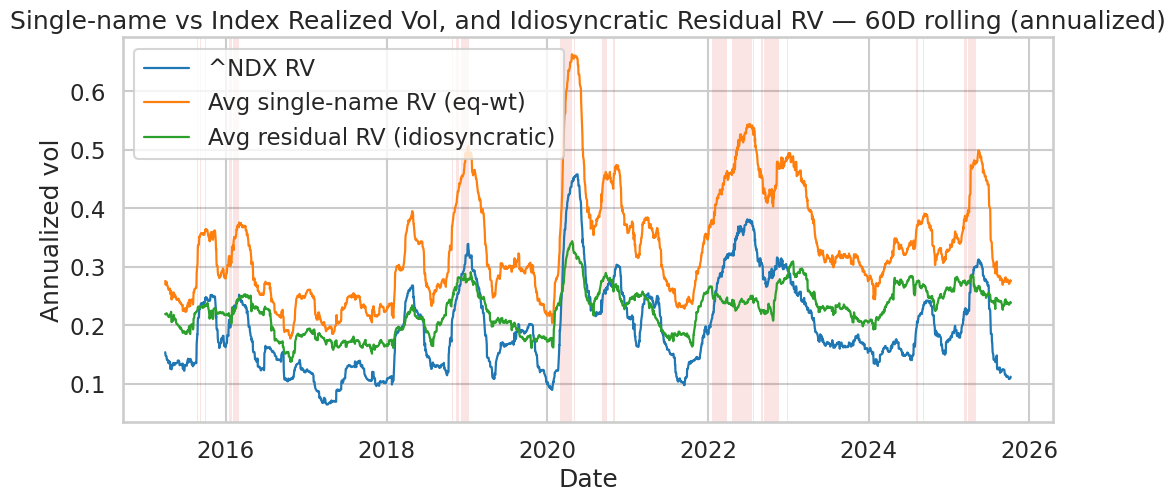

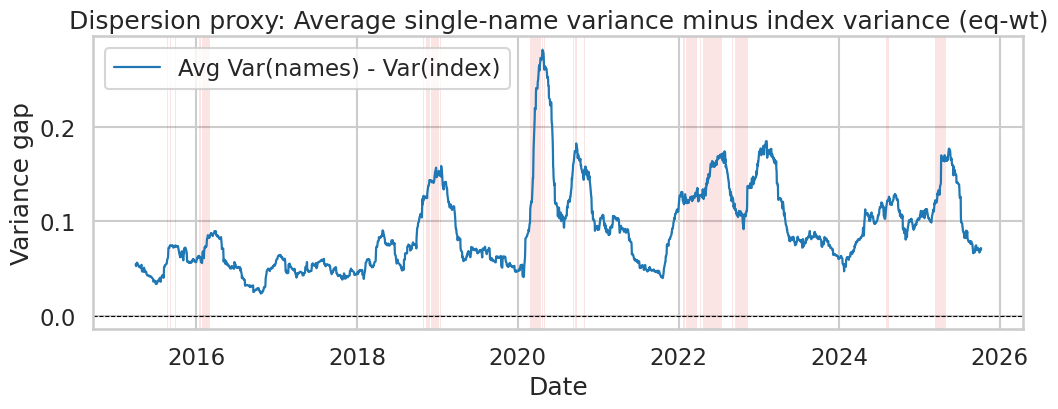


Average levels (annualized for vols):


,Crisis avg,Calm avg
^NDX RV,0.293700,0.181700
Avg single-name RV,0.450600,0.319100
Avg residual RV (idio),0.255200,0.221400
Var(names) - Var(index),0.138100,0.083600


In [41]:
#@title Visualize thesis: single-name RV vs index RV vs residual RV (split regression)
# Config
window = 60        #@param {type:"integer"}   # rolling window (trading days)
ann_factor = 252   #@param {type:"integer"}   # annualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Helper ---
def shade_crisis(ax, crisis_series, color="tab:red", alpha=0.12):
    on = False; start = None
    idx = crisis_series.index
    for t, v in crisis_series.items():
        if (v == 1) and (not on):
            on = True; start = t
        elif (v == 0) and on:
            ax.axvspan(start, t, color=color, alpha=alpha, lw=0)
            on = False
    if on:
        ax.axvspan(start, idx[-1], color=color, alpha=alpha, lw=0)

# Align core inputs
R = ret_w[[ndx_ticker] + tickers].dropna()
flag = pd.Series(crisis_flag).reindex(R.index).fillna(0).astype(int)

# --- 1️⃣ NDX realized vol (annualized) ---
rv_ndx = R[ndx_ticker].rolling(window).std() * np.sqrt(ann_factor)
rv_ndx.name = f"{ndx_ticker} RV"

# --- 2️⃣ Equal-weight average of single-name realized vols (annualized) ---
rv_names = R[tickers].rolling(window).std() * np.sqrt(ann_factor)
avg_single_rv = rv_names.mean(axis=1)
avg_single_rv.name = f"Avg single-name RV (eq-wt, {window}D)"

# --- 3️⃣ Idiosyncratic component: average residual RV (annualized, split regression) ---
resid_std = pd.DataFrame(index=R.index, columns=tickers, dtype=float)

for name in tickers:
    out = regress_single_vs_ndx_split(R[[name, ndx_ticker]].dropna(), name, ndx_ticker, crisis_flag)
    m_nc, m_c, df = out["non_crisis"], out["crisis"], out["data"]

    # merge residuals by regime
    resid_nc = m_nc.resid.reindex(R.index)
    resid_c  = m_c.resid.reindex(R.index)
    resid = pd.Series(index=R.index, dtype=float)
    resid.loc[flag == 0] = resid_nc.loc[flag == 0]
    resid.loc[flag == 1] = resid_c.loc[flag == 1]

    resid_std[name] = resid.rolling(window).std() * np.sqrt(ann_factor)

avg_resid_rv = resid_std.mean(axis=1)
avg_resid_rv.name = f"Avg residual RV (idiosyncratic, {window}D)"

# --- 4️⃣ Dispersion proxy (variance gap) ---
dispersion_var_gap = (rv_names.pow(2).mean(axis=1) - rv_ndx.pow(2)).rename("Avg Var(names) - Var(index)")

# --- 5️⃣ Plot: Index vs Single-name vs Residual RV ---
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(rv_ndx, lw=1.6, label=f"{ndx_ticker} RV")
ax.plot(avg_single_rv, lw=1.6, label="Avg single-name RV (eq-wt)")
ax.plot(avg_resid_rv, lw=1.6, label="Avg residual RV (idiosyncratic)")
shade_crisis(ax, flag)
ax.set_title(f"Single-name vs Index Realized Vol, and Idiosyncratic Residual RV — {window}D rolling (annualized)")
ax.set_xlabel("Date"); ax.set_ylabel("Annualized vol")
ax.legend(loc="upper left")
plt.show()

# --- 6️⃣ Plot: Dispersion Variance Gap ---
fig, ax = plt.subplots(figsize=(12,3.8))
ax.plot(dispersion_var_gap, lw=1.6, label="Avg Var(names) - Var(index)")
shade_crisis(ax, flag)
ax.axhline(0, color="k", ls="--", lw=0.8)
ax.set_title("Dispersion proxy: Average single-name variance minus index variance (eq-wt)")
ax.set_xlabel("Date"); ax.set_ylabel("Variance gap")
ax.legend(loc="upper left")
plt.show()

# --- 7️⃣ Summary statistics (calm vs crisis) ---
def avg_in_out(series, mask):
    a = series[mask == 1].dropna()
    b = series[mask == 0].dropna()
    return float(a.mean()) if len(a)>0 else np.nan, float(b.mean()) if len(b)>0 else np.nan

rv_ndx_c, rv_ndx_nc     = avg_in_out(rv_ndx, flag)
single_c, single_nc     = avg_in_out(avg_single_rv, flag)
resid_c, resid_nc       = avg_in_out(avg_resid_rv, flag)
gap_c, gap_nc           = avg_in_out(dispersion_var_gap, flag)

summary = pd.DataFrame({
    "Crisis avg": [rv_ndx_c, single_c, resid_c, gap_c],
    "Calm avg":   [rv_ndx_nc, single_nc, resid_nc, gap_nc]
}, index=[f"{ndx_ticker} RV", "Avg single-name RV", "Avg residual RV (idio)", "Var(names) - Var(index)"])

print("\nAverage levels (annualized for vols):")
display(summary.round(4))
